# Rocket model for Density, Advection model for Magnetic Field

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as c

#set up a current profile that is 0 before t=0 and 0 after 2*tau
def I_sin(t, tau, I0):
    if t<0:
        return 0
    if t>2*tau:
        return 0
    else:
        return I0*(np.sin(np.pi*t/(2*tau)))**2
I = np.vectorize(I_sin)

def lineout(data, start, stop):
    length=np.sqrt((stop[0]-start[0])**2+(stop[1]-start[1])**2)
    xs, ys=np.linspace(start[0], stop[0], length), np.linspace(start[1], stop[1], length)
    lineout = data[xs.astype(np.int), ys.astype(np.int)]
    return lineout

## Parameters for model

In [43]:
I0=1.0e6/2 #amps
tau=250e-9 #seconds
t=235e-9 #seconds
A=12 #atomic mass units
Z=4 #effective ion charge
V=40e3 #in m/s
R0=8e-3 #radius of array
lamb=1053e-9#laser probing wavelength for Faraday, metres.

#include all the plasma in our profiles so the integration misses nothing.
RMax=R0+t*V #furthest distance plasma can travel
XMax=np.sqrt(RMax**2-R0**2) #distance in X plasma has travelled at y=R0.

xs=np.linspace(-XMax,XMax,1e3)# in metres, form is (minimum, maximum, number of points)
ys=np.linspace(R0,RMax,1e3)# in metres, form is (minimum, maximum, number of points)
dx=(xs.max()-xs.min())/float(xs.size)
dy=(ys.max()-ys.min())/float(ys.size)
X, Y= np.meshgrid(xs, ys)
R=np.sqrt(Y**2+X**2) #distance from centre of array to each point, m
ret_time=t-(R-R0)/V#retarded time taken to reach each point, seconds
ne=(c.mu_0*Z)/(8*np.pi**2*V**2*R0*R*A*c.m_p)*(I(ret_time, tau, I0))**2 #electron density, m^-3
B=c.mu_0/(2*np.pi*R0)*I(ret_time, tau, I0)#magnetic field magnitude, T
th=np.arctan(X/Y)#angle between x axis and line from the radius
b_hat=np.array([[np.cos(the),np.sin(the)] for the in th]) #unit vector pointing in mangetic field direction
Bx=B*b_hat[:,0] #component of B field in x direction
By=B*b_hat[:,1]

neL=1e-4*np.sum(ne, axis=1)*dx #line average electron density cm^-2
alpha=2.62e-13*lamb**2*np.sum(Bx*ne, axis=1)*dx #rotation angle, radians
Bmax=B[:, ys.size/2] #peak magnetic field along any radial direction - this is what we are trying to extract
Bavg=3.4e20*alpha/(neL) #x component of magnetic field inferred by current analysis techniques.
beta_kin=(c.mu_0*A*1.67e-27*ne/Z*V**2)/B**2#CGS formulation


C:\Users\jdavies\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\jdavies\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jdavies\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


## Single Exploder Model

### Plot profiles along chord of n_e and B

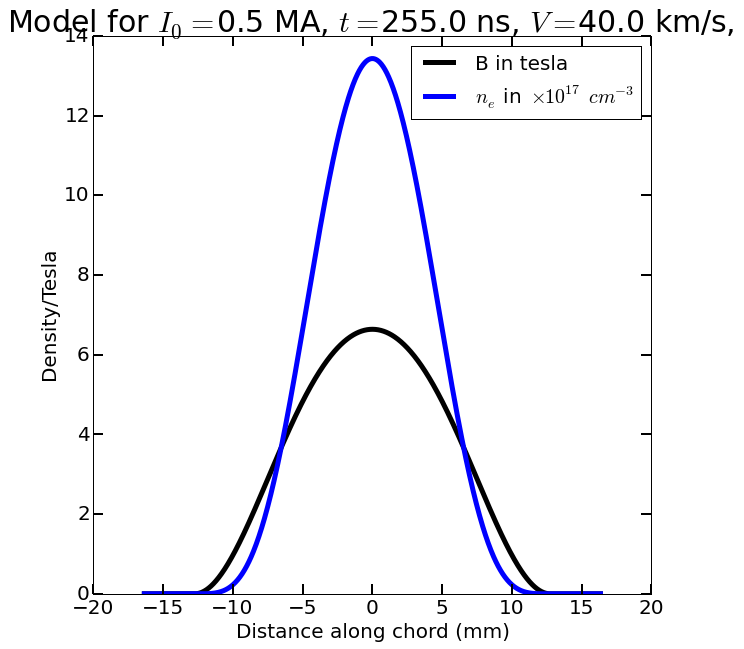

In [17]:
y=13e-3#metres, distance from centre in direction perpendicular to line of sight

y_ind=np.where(y<ys)[0][0]
fig, ax=plt.subplots(figsize=(10,10))
ax.plot(xs*1e3, B[y_ind,:], lw=5, color='k', label=r'B in tesla') 
ax.plot(xs*1e3, ne[y_ind,:]/1e23,lw=5,color='b', label=r'$n_e$ in $\times 10^{17}\,cm^{-3}$')
ax.legend(fontsize=20)

ax.set_xlabel(r'Distance along chord (mm)',fontsize=20)
ax.set_ylabel('Density/Tesla',fontsize=20)
ax.tick_params(labelsize=20, pad=5, length=10, width=2)

I0str=r'$I_0=$'+str(I0/1e6)+' MA, '
tstr=r'$t=$'+str(t*1e9)+' ns, '
Vstr=r'$V=$'+str(V/1e3)+' km/s, '
ax.set_title('Model for '+I0str+tstr+Vstr, fontsize=30)

#ax.set_ylim([0,1.4])

### Plot profiles of parameters perpendicular to line of sight

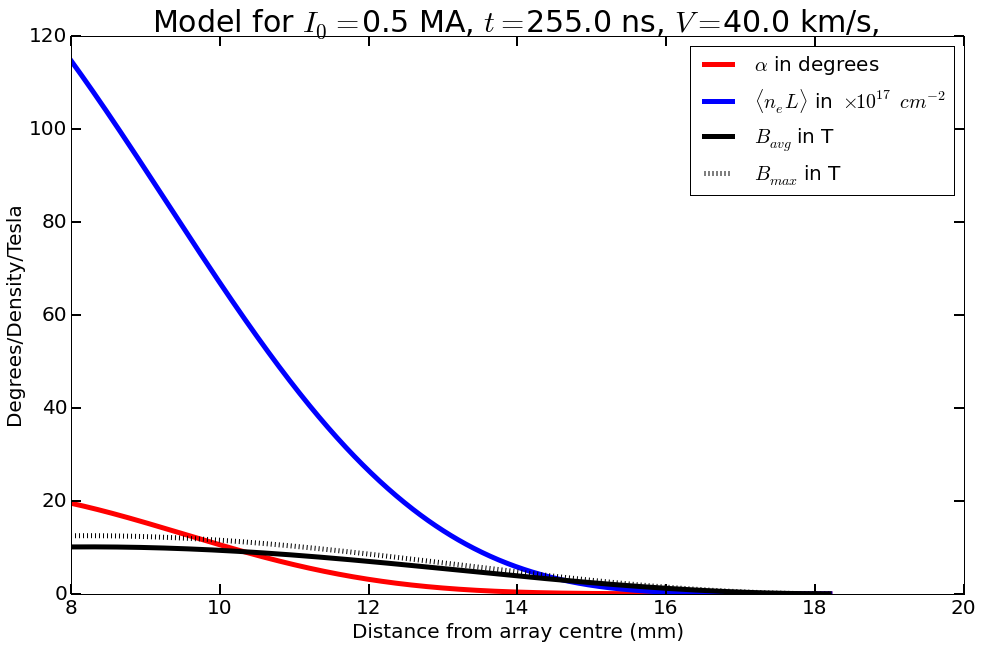

In [18]:
fig, ax=plt.subplots(figsize=(16,10))
ax.plot(ys*1e3, alpha*(180/np.pi), lw=5, color='r', label=r'$\alpha$ in degrees') #convert to degrees
ax.plot(ys*1e3, neL/1e17,lw=5,color='b', label=r'$\langle n_e L \rangle$ in $\times 10^{17}\,cm^{-2}$')
ax.plot(ys*1e3, Bavg, lw=5,color='k', label=r'$B_{avg}$ in T')
ax.plot(ys*1e3, Bmax, ':',lw=5, color='k', label=r'$B_{max}$ in T')
ax.legend(fontsize=20)

ax.set_xlabel(r'Distance from array centre (mm)',fontsize=20)
ax.set_ylabel('Degrees/Density/Tesla',fontsize=20)
ax.tick_params(labelsize=20, pad=5, length=10, width=2)

I0str=r'$I_0=$'+str(I0/1e6)+' MA, '
tstr=r'$t=$'+str(t*1e9)+' ns, '
Vstr=r'$V=$'+str(V/1e3)+' km/s, '
ax.set_title('Model for '+I0str+tstr+Vstr, fontsize=30)

#ax.set_ylim([0,1.4])

## Double Exploder Model

### Plot profiles perpendicular to line of sight with interaction region

C:\Users\jdavies\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\jdavies\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


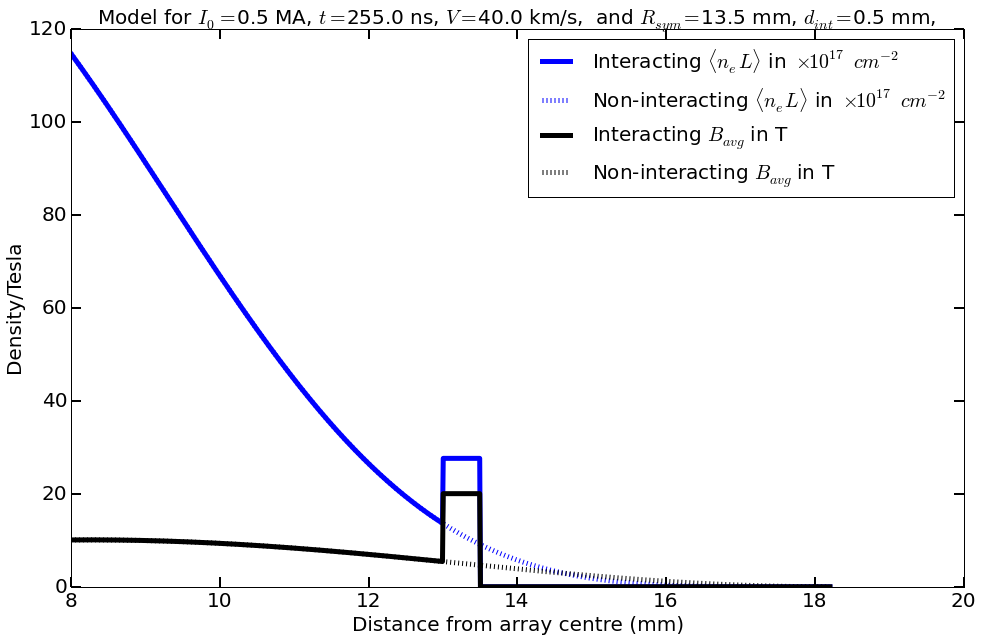

In [20]:
'''
Change R_sym and d_int only to change location and thickness of interaction region
'''
R_sym=13.5e-3#distance to plane of symmetry
d_int=0.5e-3#half width of interaction region

cutoff_ind=np.where((R_sym-d_int)<ys)[0][0]
sym_ind=np.where(R_sym<ys)[0][0]

ne_interacted=np.trapz(ne[cutoff_ind:,:],dx=dy,axis=0)/d_int
ne_int=np.zeros_like(ne)
ne_int[:cutoff_ind,:]=ne[:cutoff_ind,:]
ne_int[cutoff_ind:sym_ind,:]=ne_interacted

Bx_interacted=np.trapz(Bx[cutoff_ind:,:], dx=dy,axis=0)/d_int
Bx_int=np.zeros_like(Bx)
Bx_int[:cutoff_ind,:]=Bx[:cutoff_ind,:]
Bx_int[cutoff_ind:sym_ind,:]=Bx_interacted

neL_int=1e-4*np.sum(ne_int, axis=1)*dx #line average electron density cm^-2
alpha_int=2.62e-13*lamb**2*np.sum(Bx_int*ne_int, axis=1)*dx #rotation angle, radians
Bmax_int=Bx_int[:, ys.size/2] #peak magnetic field along any radial direction - this is what we are trying to extract
Bavg_int=3.4e20*alpha_int/(neL_int) #x component of magnetic field inferred by current analysis techniques.
Bavg_int[sym_ind:]=0

fig, ax=plt.subplots(figsize=(16,10))
ax.plot(ys*1e3, neL_int/1e17, lw=5, color='b', label=r'Interacting $\langle n_e L \rangle$ in $\times 10^{17}\,cm^{-2}$')
ax.plot(ys*1e3, neL/1e17, lw=5, ls=':', color='b', label=r'Non-interacting $\langle n_e L \rangle$ in $\times 10^{17}\,cm^{-2}$')
ax.plot(ys*1e3, Bavg_int, lw=5, color='k', label=r'Interacting $B_{avg}$ in T')
ax.plot(ys*1e3, Bavg, lw=5, ls=':',color='k', label=r'Non-interacting $B_{avg}$ in T')
ax.legend(fontsize=20)

ax.set_xlabel(r'Distance from array centre (mm)',fontsize=20)
ax.set_ylabel('Density/Tesla',fontsize=20)
ax.tick_params(labelsize=20, pad=5, length=10, width=2)

I0str=r'$I_0=$'+str(I0/1e6)+' MA, '
tstr=r'$t=$'+str(t*1e9)+' ns, '
Vstr=r'$V=$'+str(V/1e3)+' km/s, '
R_sym_str=r'$R_{sym}=$'+str(R_sym*1e3)+' mm, '
d_int_str=r'$d_{int}=$'+str(d_int*1e3)+' mm, '
ax.set_title('Model for '+I0str+tstr+Vstr+' and '+R_sym_str+d_int_str, fontsize=20)

## Lineouts

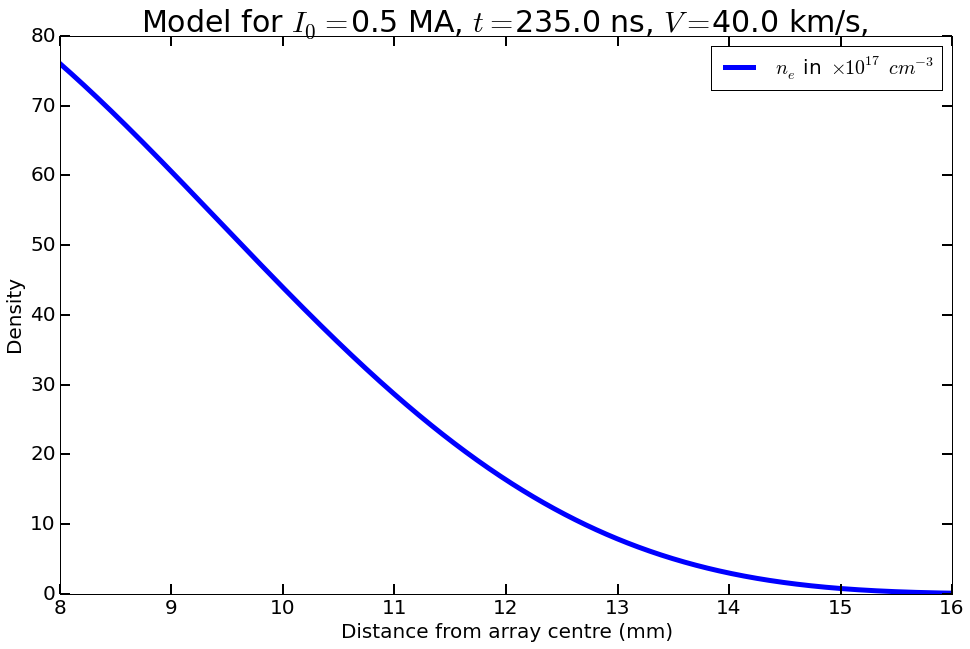

In [44]:
#lo=lineout(ne, (0,500), (1000, 500))
fig, ax=plt.subplots(figsize=(16,10))
ax.plot(ys*1e3, ne[:,500]/1e23,lw=5,color='b', label=r'$n_e$ in $\times 10^{17}\,cm^{-3}$')
ax.legend(fontsize=20)

ax.set_xlabel(r'Distance from array centre (mm)',fontsize=20)
ax.set_ylabel('Density',fontsize=20)
ax.tick_params(labelsize=20, pad=5, length=10, width=2)
ax.set_ylim([0,80])
ax.set_xlim([8,16])

I0str=r'$I_0=$'+str(I0/1e6)+' MA, '
tstr=r'$t=$'+str(t*1e9)+' ns, '
Vstr=r'$V=$'+str(V/1e3)+' km/s, '
ax.set_title('Model for '+I0str+tstr+Vstr, fontsize=30)

In [34]:
lo.size

999

In [9]:
H=20e-3#height of array
total_flux = np.trapz(Bx, dx=dy,axis=0)*H #T m^2 integrate flux along flow direction
ion_gyro_flux=(p.rho_i*1e-2)**2*np.pi*6 #6T flux contained by one ion gyro radius converted to m
total_flux[250]/ion_gyro_flux

5317.526193244872

## Comparison to Data (not functional)

In [2]:
fig, ax=plt.subplots(figsize=(16,10))
plot=ax.plot(x*1e3, Bx, lw=5)
plot=ax.plot(x*1e3, ne/1e17, lw=5)
#plot1=ax.plot(x_data, slice1/1.8, lw=5)

#ax.set_xlim([-5,5])
#ax.set_xticks(np.arange(-5,5+1,1))
ax.set_xlabel('Distance from centre (mm)', fontsize=24)
#ax.set_ylabel(r'Line integrated electron density ($\times10^{21}\,cm^{-2}$)',fontsize=24)
ax.tick_params(labelsize=20, pad=5, length=10, width=2)
#ax.set_title('s0513_15: Magnetic field and Electron density',fontsize=36)

In [13]:
data=np.loadtxt(open('s0513_15 end on ne.txt',"r"),delimiter=",")
avg_rows=10
y1=1165
y2=2205
slice1=np.mean(data[y1-avg_rows:y1+avg_rows,:],0)
slice2=np.mean(data[y2-avg_rows:y2+avg_rows,:],0)
x_data=(np.arange(0, data.shape[1])-2463)/173.3

IOError: [Errno 2] No such file or directory: 's0513_15 end on ne.txt'

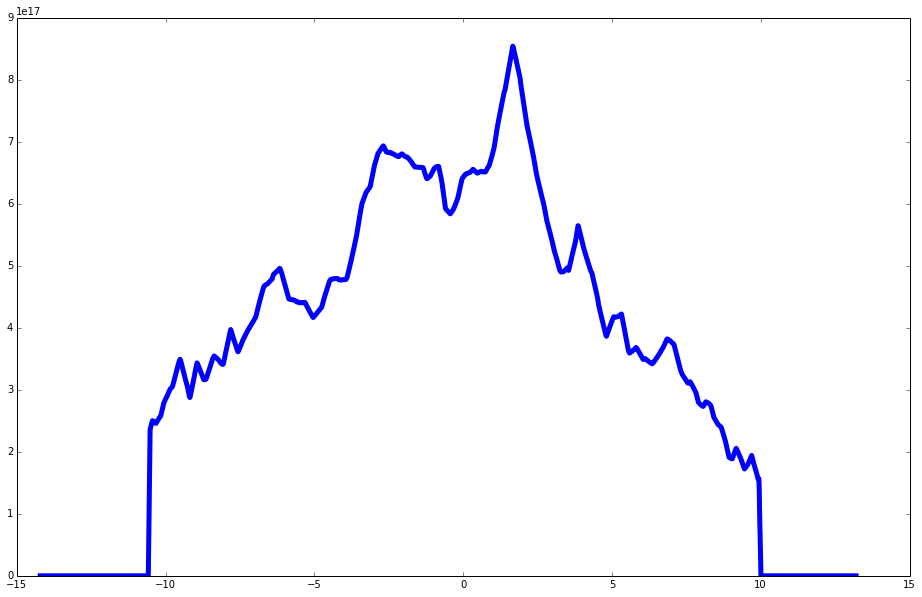

In [42]:
fig, ax=plt.subplots(figsize=(16,10))
plot1=ax.plot(x_data, slice1, lw=5)
#plot1=ax.plot(x_data, slice2, lw=5)